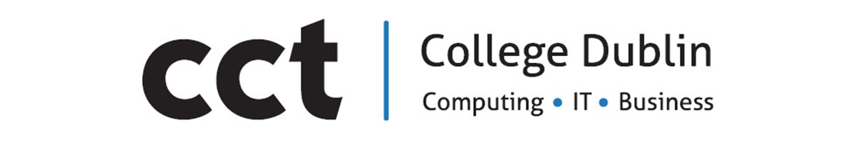

<h1 align="center">Subject: Machine Learning</h1>
<h2 align="center">Lecturer: David McQuaid</h2>
<h3 align="center">Caio Machado de Oliveira</h3>
<h4 align="center">ID: 2020351</h4>
<h5 align="center">April/2024</h5>


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_csv("crime-per-county.csv")

data.head()

,STATISTIC Label,Quarter,Garda Division,Type of Offence,UNIT,VALUE
0,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Homicide offences,Number,1.0
1,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Murder,Number,0.0
2,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Manslaughter,Number,0.0
3,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Infanticide,Number,0.0
4,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Dangerous driving leading to death,Number,1.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166992 entries, 0 to 166991
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATISTIC Label  166992 non-null  object 
 1   Quarter          166992 non-null  object 
 2   Garda Division   166992 non-null  object 
 3   Type of Offence  166992 non-null  object 
 4   UNIT             166992 non-null  object 
 5   VALUE            166383 non-null  float64
dtypes: float64(1), object(5)
memory usage: 7.6+ MB


In [4]:
data.drop(columns =["STATISTIC Label", "UNIT"], inplace=True)

In [5]:
data['VALUE'] = data['VALUE'].fillna(0)


In [6]:
data['VALUE'] = data['VALUE'].astype('int64')

In [7]:
data.describe()

,VALUE
count,166992.000000
mean,58.784056
std,149.422177
min,0.000000
25%,0.000000
50%,4.000000
75%,46.000000
max,2541.000000


In [8]:
data = data[data['VALUE'] != 0]

In [9]:
data.info() 
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 120808 entries, 0 to 166991
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Quarter          120808 non-null  object
 1   Garda Division   120808 non-null  object
 2   Type of Offence  120808 non-null  object
 3   VALUE            120808 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 4.6+ MB


,VALUE
count,120808.000000
mean,81.256763
std,170.400775
min,1.000000
25%,2.000000
50%,16.000000
75%,86.000000
max,2541.000000


In [14]:
data.rename(columns = {'Type of Offence': 'Offence', 'VALUE': 'Crime'}, inplace=True)

In [15]:
data.head()

,Quarter,Garda Division,Offence,Crime
0,2003Q1,Cavan/Monaghan Garda Division,Homicide offences,1
4,2003Q1,Cavan/Monaghan Garda Division,Dangerous driving leading to death,1
5,2003Q1,Cavan/Monaghan Garda Division,Sexual offences,23
6,2003Q1,Cavan/Monaghan Garda Division,Rape and sexual assault,23
8,2003Q1,Cavan/Monaghan Garda Division,"Attempts/threats to murder, assaults, harassme...",128


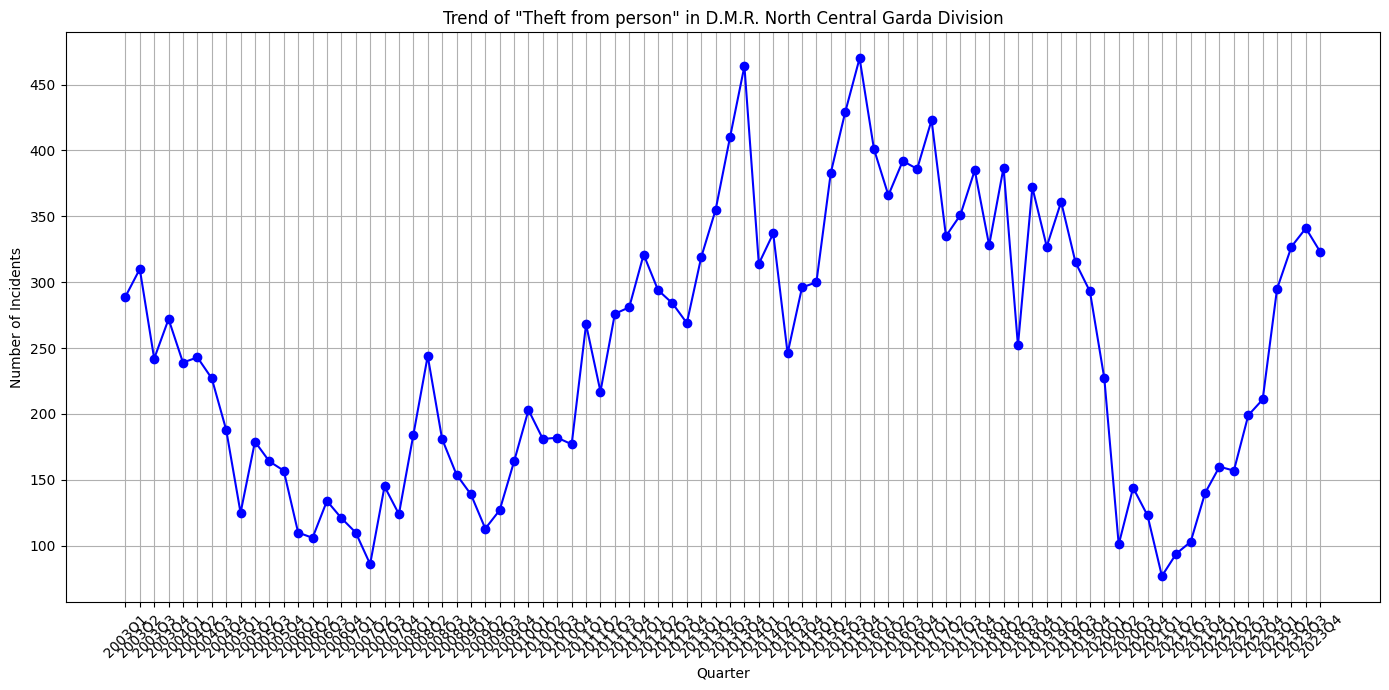

In [16]:
# Filter the data for "Theft from person" crimes in "D.M.R. North Central Garda Division"
theft_from_person_data = data[
    (data['Offence'] == 'Theft from person') & 
    (data['Garda Division'] == 'D.M.R. North Central Garda Division')
]

# Pivot to get a time series of "Theft from person" crimes for D.M.R. North Central Garda Division
theft_from_person_time_series = theft_from_person_data.pivot_table(values='Crime', index='Quarter', aggfunc='sum')

# Plotting the line graph
plt.figure(figsize=(14, 7))
plt.plot(theft_from_person_time_series.index, theft_from_person_time_series['Crime'], marker='o', linestyle='-', color='b')
plt.title('Trend of "Theft from person" in D.M.R. North Central Garda Division')
plt.xlabel('Quarter')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()


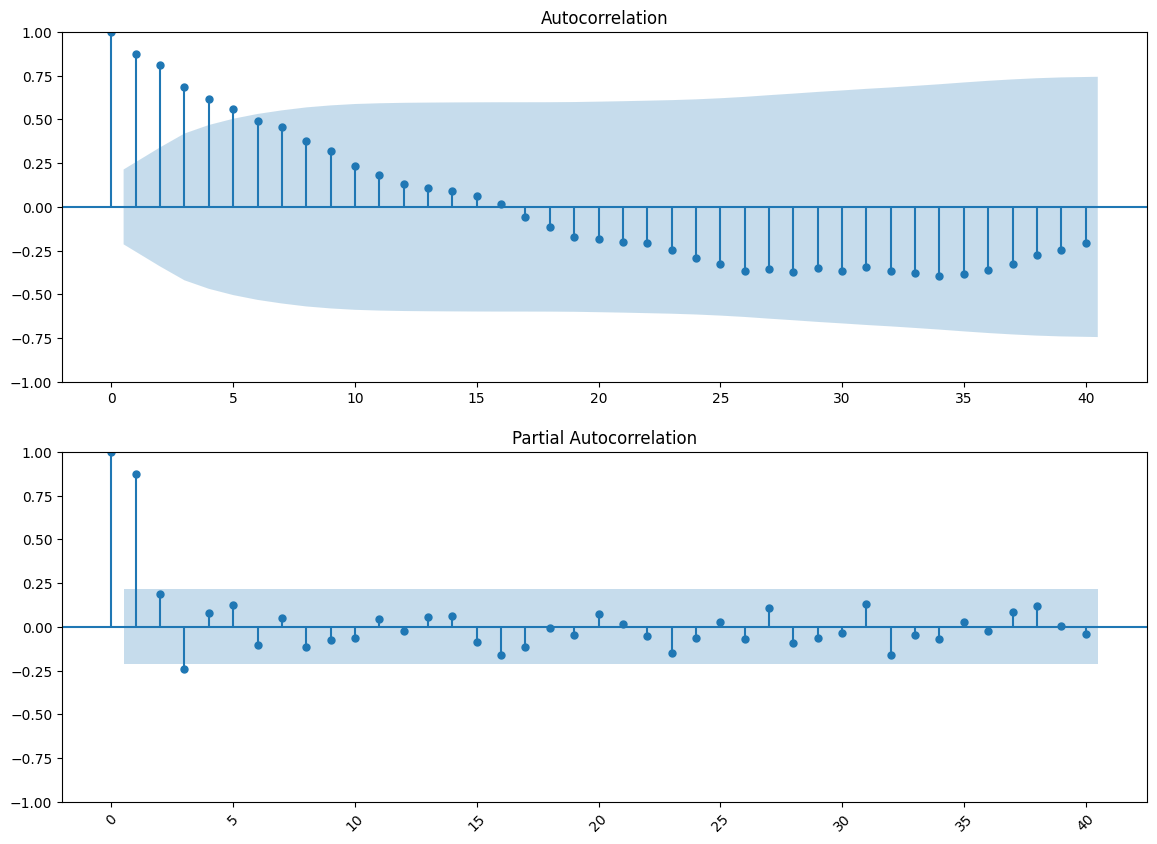

((-2.1574690536953205,
  0.22204207743186055,
  2,
  81,
  {'1%': -3.5137900174243235,
   '5%': -2.8979433868293945,
   '10%': -2.5861907285474777},
  757.4328813516775),
 <Figure size 640x480 with 4 Axes>)

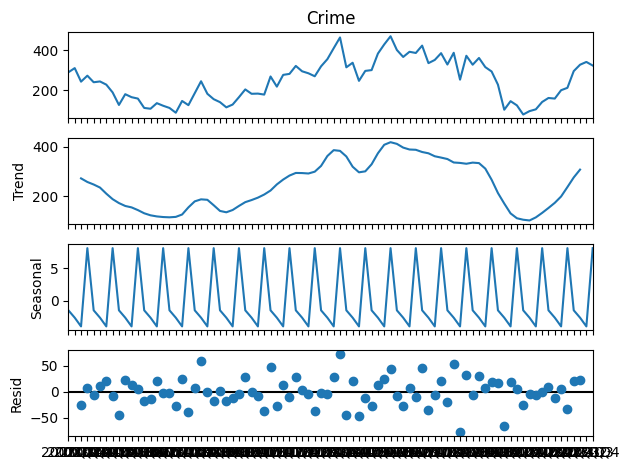

In [29]:
# Perform Augmented Dickey-Fuller test to check for stationarity
adf_test = adfuller(theft_from_person_time_series['Crime'])

# Seasonal Decomposition
decomposition = seasonal_decompose(theft_from_person_time_series['Crime'], model='additive', period=4)

# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(theft_from_person_time_series['Crime'], lags=40, ax=ax1)
plot_pacf(theft_from_person_time_series['Crime'], lags=40, ax=ax2)
plt.show()

# Results
adf_test, decomposition.plot()


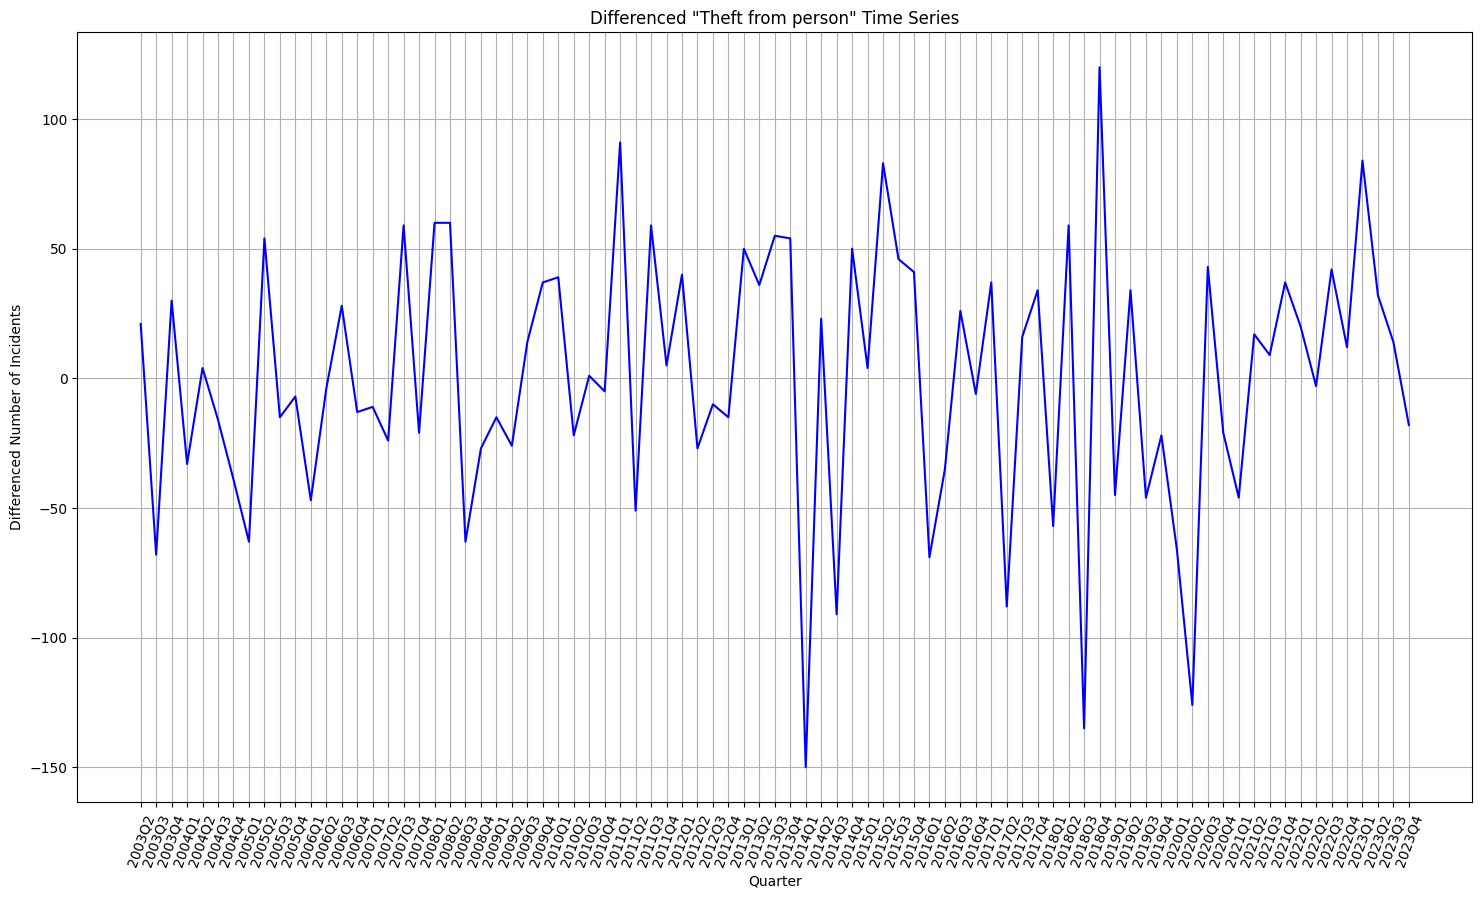

(-5.677389627529372,
 8.641840469916911e-07,
 1,
 81,
 {'1%': -3.5137900174243235,
  '5%': -2.8979433868293945,
  '10%': -2.5861907285474777},
 750.8607249360291)

In [42]:
# Differencing the data to make it stationary
theft_from_person_diff = theft_from_person_time_series['Crime'].diff().dropna()

# Re-running the Augmented Dickey-Fuller test on the differenced data
adf_test_diff = adfuller(theft_from_person_diff)

# Plotting the differenced data
plt.figure(figsize=(18, 10))
plt.plot(theft_from_person_diff, color='blue')
plt.title('Differenced "Theft from person" Time Series')
plt.xlabel('Quarter')
plt.ylabel('Differenced Number of Incidents')
plt.grid(True)
plt.xticks(rotation=70)
plt.show()

adf_test_diff

ADF Statistic: -5.677389627529372

This is the test statistic for the ADF test. The more negative this statistic, the stronger the rejection of the null hypothesis that there is a unit root (i.e., the series is non-stationary).
p-value: 8.641840469916911e-07

This is the probability of observing the data if the null hypothesis is true. A very low p-value (typically < 0.05) means you can reject the null hypothesis of non-stationarity. In your case, the p-value is significantly low, indicating that the time series does not have a unit root and is stationary.
Lags Used: 1

This indicates the number of lags used in the regression when performing the ADF test.
Number of Observations Used: 81

This tells you how many observations were used in the ADF test after adjusting for lags.
Critical Values:

These values define the threshold at which the ADF test statistic should be compared to conclude whether the time series is stationary.
For a confidence level of 99%, 95%, and 90%, the critical values are -3.51, -2.90, and -2.59, respectively.
Maximized Information Criterion if autolag is not None: 75ity of the series.

In [43]:
# Label Encoding (using factorize)
label_encoded = data.copy()
for column in ['Garda Division', 'Offence']:
    label_encoded[column] = pd.factorize(label_encoded[column])[0]

print("\nLabel Encoded:")
print(label_encoded)



Label Encoded:
       Quarter  Garda Division  Offence  Crime
0       2003Q1               0        0      1
4       2003Q1               0        1      1
5       2003Q1               0        2     23
6       2003Q1               0        3     23
8       2003Q1               0        4    128
...        ...             ...      ...    ...
166983  2023Q4              27       41      8
166986  2023Q4              27       42      3
166987  2023Q4              27       43    390
166988  2023Q4              27       44      5
166991  2023Q4              27       46    385

[120808 rows x 4 columns]


In [44]:
from statsmodels.tsa.stattools import adfuller
def ad_test(data):
    datasettest = adfuller(data, autolag = 'AIC')
    print("1. ADF : ", datasettest[0])
    print("2. P-value : ", datasettest[1])
    print("3. Num of Lags: ", datasettest[2])
    print("4. Num of observations used for ADF regression and critical values calculation : ", datasettest[3])
    print("5. Critical values : ")
    for key, val in datasettest[4].items():
        print("\t", key, ": ", val)

In [46]:
ad_test(data['Crime'])

1. ADF :  -27.34786022361855
2. P-value :  0.0
3. Num of Lags:  71
4. Num of observations used for ADF regression and critical values calculation :  120736
5. Critical values : 
	 1% :  -3.4304041631248015
	 5% :  -2.861563939297898
	 10% :  -2.566782742042685


In [ ]:
from pmdarima import auto_arima

import warnings 
warnings.filterwarnings("ignore")